## Imports, train_test loop, saliency map plotting function, training loss plotting function, dataloader

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import os

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0])

        image = Image.open(img_path).convert("RGB")  # Ensure images are RGB
        img_path = img_path[::-1]
        x = img_path[:img_path.find("/")]
        x = x[::-1]
        # print(x)
        x = x[x.find("_")+1:-4]
        t = x.find("_")
        hr = int(x[:t])
        mn = int(x[t+1:])
        label = hr*60+mn - 60
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),           # Convert image to PyTorch tensor
    # Add more transformations as needed
])

# # Path to the CSV file
csv_file = "Naman/monochrome/clock_minute_hand/new.csv"
# # Path to the folder containing images
root_dir = "Naman/monochrome/clock_minute_hand/samples"

# Create the custom dataset
custom_dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

# # Example usage of the dataset
image, label = custom_dataset[0]
print("Label:", label)
print("Image shape:", image.shape)




Label: 137
Image shape: torch.Size([3, 224, 224])


In [29]:
labels_set = set()
for i in custom_dataset:
    labels_set.add(i[1])


In [30]:
len(labels_set), min(labels_set), max(labels_set)

(720, 0, 719)

421


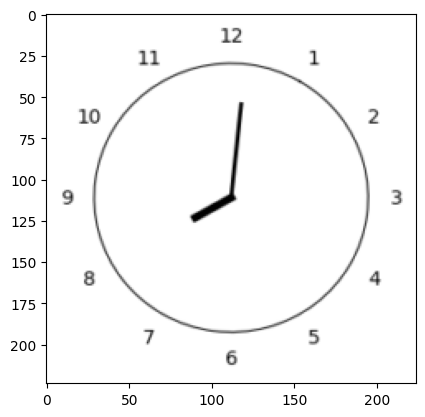

In [31]:
i=5
inp = custom_dataset[i][0]
print(custom_dataset[i][1])
plt.imshow(inp.permute(1,2,0))

In [32]:

# Define the size of the training and testing sets
train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size

# Split the dataset randomly into training and testing sets
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

# Example of accessing the length of the train and test datasets
print("Training dataset size:", len(train_dataset))
print("Testing dataset size:", len(test_dataset))




# Example usage of the dataset
# Access the first image and its label
image, label = custom_dataset[0]
print("Label:", label)
print("Image shape:", image.shape)

# Create a DataLoader to load the dataset in batches
batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Example usage of the data loader
for images, labels in train_data_loader:
    # Training loop or any other processing here
    print("Batch Images shape:", images.shape)
    print("Batch Labels:", labels)
    break  # Break after the first batch

Training dataset size: 7999
Testing dataset size: 2000
Label: 137
Image shape: torch.Size([3, 224, 224])
Batch Images shape: torch.Size([32, 3, 224, 224])
Batch Labels: tensor([385,  53,  16, 333,  56, 324, 481, 241, 481,  97, 649, 149, 638, 562,
        301,   9, 198, 506, 440, 215, 116, 487, 175, 557, 186,  18, 365, 458,
        630, 252, 207, 460])


tensor(204)


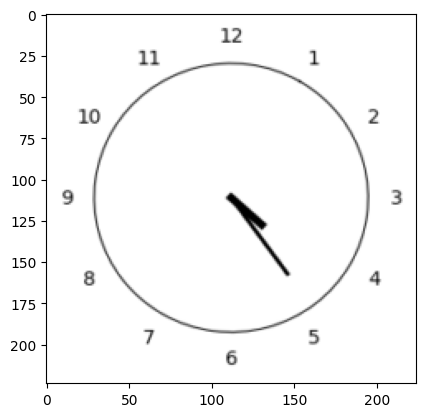

In [33]:
for inputs,labels in test_data_loader:
    x = inputs[0]
    y = labels[0]

    plt.imshow(x.permute(1,2,0))
    print(y)
    break

199


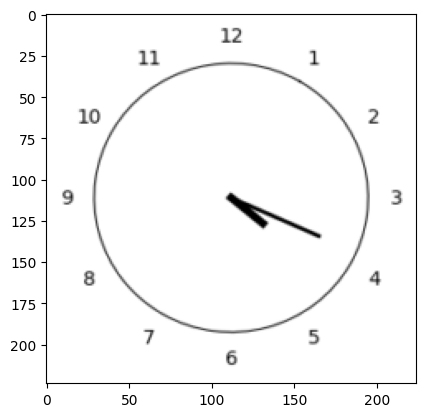

In [34]:
i=13
inp = test_dataset.__getitem__(i)[0]
print(test_dataset.__getitem__(i)[1])
plt.imshow(inp.permute(1,2,0))

In [35]:
from glob import glob

import matplotlib.pyplot as plt

import os

from PIL import Image

from sklearn.metrics import accuracy_score, recall_score

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torchvision import datasets

import warnings
warnings.filterwarnings("ignore")


In [36]:
def train_test_loop(model, num_epochs, train_loader, test_loader, criterion, optimizer, device):
    #shifting the model to device
    model.to(device)
    Loss = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            #shifting the inputs and the labels to same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            #resetting the gradient values
            optimizer.zero_grad()

            #computing the model output for the datapoint
            outputs = model(inputs)

            #computing the loss
            loss = criterion(outputs, labels)

            #backpropagating the loss
            loss.backward()

            #updating the gradients
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        Loss.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    #evaluation
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    recall = recall_score(all_labels, all_predictions, average='weighted')
    accuracy = correct/total
    return model, Loss, accuracy, recall

In [37]:
# Function for plotting the training and validation loss
def plot_train_loss(training_loss, title):
    plt.plot(training_loss, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

## Model loading and training

In [38]:
#loading pre-trained ResNet18
resnet = torchvision.models.resnet18(pretrained=True)

#freeze all layers except the last one
for name, param in resnet.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = True

#modifying the last layer to fit the number of classes in your dataset
num_classes = 720 # for minute hand
# num_classes = 20  # for hour hand
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

#defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

num_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
trained_model1, loss1, acc1, recall1 = train_test_loop(resnet, num_epochs, train_data_loader, test_data_loader, criterion, optimizer, device)

In [ ]:
print(acc1)

0.729


tensor([421])
tensor([421], device='cuda:0')


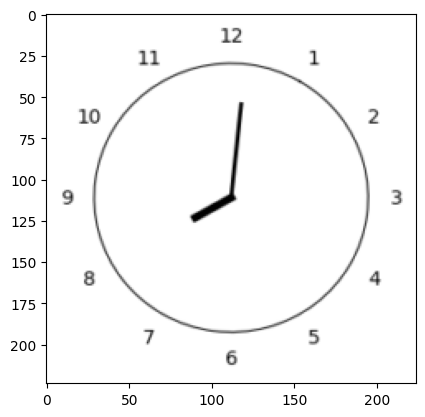

In [ ]:
#test loader for saliency map with batch size of 1
test_loader2 = DataLoader(test_dataset, batch_size=1, shuffle=True)
inp = 0
with torch.no_grad():
	for inputs, labels in test_loader2:
		inputs, labels = inputs.to(device), labels.to(device)
		inp = inputs
		outputs = trained_model1(inputs)
		_, predicted = torch.max(outputs.data, 1)
		print(predicted.detach().cpu())
		print(labels)
		break


inp = inp[0].detach().cpu()

plt.imshow(inp.permute(1,2,0))


In [ ]:
def conv_pred_to_time(pred):
    h = (pred+60) // 60
    m = pred % 60
    return [h, m]

tensor([314], device='cuda:0')
[6, 14]


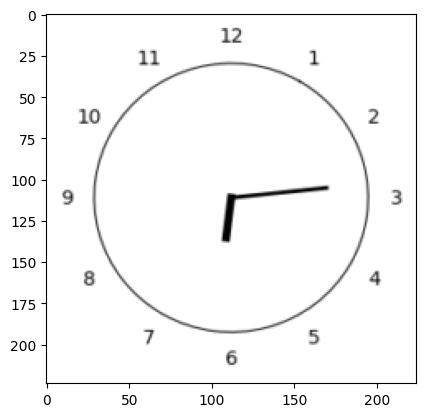

In [ ]:
# test_image1 = Image.open("Naman/rotated_clocks/test/1-00/10.jpg")
# test_image1 = Image.open("Naman/test_folder/test3.jpeg")
# test_image1 = Image.open("Naman/analog_clocks/samples/3.jpg")
test_image1 = Image.open("Naman/monochrome/clock_minute_hand/samples/1039_6_14.png").convert("RGB")


test_image1 = transform(test_image1)
test_image1 = test_image1.unsqueeze(0)
test_image1 = test_image1.to(device)

test_outputs = trained_model1(test_image1)
test_, test_predicted = torch.max(test_outputs.data, 1)

print(test_predicted)
print(conv_pred_to_time(test_predicted.detach().cpu().numpy()[0]))
# print(labels_dict[test_predicted.detach().cpu().numpy()[0]])
plt.imshow(test_image1[0].detach().cpu().permute(1,2,0))


In [ ]:
path_img = "./Naman/monochrome/clock_minute_hand/samples/0_6_59.png"
path_img.split("/")[-1].split('.')[0].split("_")[1:]




['6', '59']

In [ ]:
test_image1 = Image.open("Naman/real-world/Images/Images/0.jpg")
